<a href="https://colab.research.google.com/github/sheldonlll/F_T_backup/blob/main/Forgetting_TracIn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime

import torch
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets
from torch import optim

from torchvision.transforms import transforms

lr = 1e-3
test_batch_size = 500
train_batch_size = 2500
epoches = 42

checking_points_cpts1 = "./cpts1/"
checking_points_cpts2 = "./cpts2/"

data_transform = {
"train": transforms.Compose([transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

"val": transforms.Compose([transforms.Resize((32, 32)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

acc_detail_per_epoch_file_path = "./acc_per_epoch_detail_lst.txt"
forgetting_score_results = "./forgetting_score_results.txt"
TracIn_results = "./Tracin_results"
TracIn_original_train_indexes_original_test_indexes = "./TracIn_original_train_indexes_original_test_indexes"

In [ ]:
import torch.nn as nn
import torch

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, block_nums, num_classes = 1000, include_top= True, groups = 1, width_per_group = 64) -> None:
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64
        self.groups = groups
        self.width_per_group = width_per_group
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(block, 64, block_nums[0])
        self.layer2 = self._make_layer(block, 128, block_nums[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, block_nums[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, block_nums[3], stride = 2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = "fan_out", nonlinearity = "relu")
    
    def _make_layer(self, block, channel, block_num, stride = 1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(channel * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample = downsample,
                            stride = stride,
                            groups = self.groups,
                            width_per_group = self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x

def resnet34(num_classes=1000, include_top=True):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes = num_classes, include_top = include_top)


In [ ]:
import torchvision.transforms as transforms
import torchvision
import torch
def dataset_get():
    pass

def dataset_category_get(category_num, train_size, test_size, train_dataloader, test_dataloader):
    data_transform = {
        "train": transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),# converts images loaded by Pillow into PyTorch tensors.
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),

        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    } # transform incoming images into a Pytorch Tensor
    
    
    test_set = torchvision.datasets.CIFAR10(root = "datasets", train = False, download = False, transform = data_transform["val"])
    test_loader = torch.utils.data.DataLoader(test_set, batch_size = test_size, shuffle = False, num_workers = 0)

    train_set = torchvision.datasets.CIFAR10(root = "datasets", train = False, download = False, transform = data_transform["train"])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_size, shuffle = False, num_workers = 0)
    
    train_data_iter = iter(train_loader)
    train_image, train_label = train_data_iter.next()

    img_all_train = torch.zeros(train_size, 3, 224, 224) # 存放train_image中所有标签是参数category_num的图片作为训练数据集
    train_image_num = 0 # img_all_train数组的当前数量/下标


    original_train_indexes = []
    original_test_indexes = []

    for i in range(min(train_size, len(train_dataloader))):
        if (train_label[i] == category_num):
            img_all_train[train_image_num] = train_image[i]
            train_image_num += 1
            original_train_indexes.append(i)
        if train_image_num == train_size:
            break
    


    test_data_iter = iter(test_loader)
    test_image, test_label = test_data_iter.next()

    img_all_test = torch.zeros(test_size, 3, 224, 224) # 存放test_image中所有标签是参数category_num的图片作为训练数据集
    test_image_num = 0 # img_all_train数组的当前数量/下标

    for i in range(min(test_size, len(test_dataloader))):
        if (test_label[i] == category_num):
            img_all_test[test_image_num] = test_image[i]
            test_image_num += 1
            original_test_indexes.append(i)
        if test_image_num == test_size:
            break
    
    return img_all_train, img_all_test, original_train_indexes, original_test_indexes # shape: (train_size, 3, 224, 224), (test_size, 3, 224, 224)

In [ ]:
import time
import os
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_train_indexes, original_test_indexes = [], []


def get_gradient(grads, model):
    return [grad for grad, (n, p) in zip(grads, model.named_parameters())]


def tracin_get(a, b):
    return sum([torch.dot(at.flatten(), bt.flatten()) for at, bt in zip(a, b)])


def calculate_tracin(category_num, path, file_name, learning_rate, batch_size, train_dataloader, test_dataloader):
    model_weight_path = path + file_name
    assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)

    net = resnet34()
    checkpoint = torch.load(model_weight_path, map_location = device)
    net.load_state_dict(checkpoint["state_dict"])
    net.to(device = device)

    loss_fn = nn.CrossEntropyLoss()

    global original_train_indexes
    global original_test_indexes
    
    train_size = 500
    test_size = 100


    img_all_train, img_all_test, original_train_indexes, original_test_indexes = dataset_category_get(category_num = category_num, train_size = train_size, test_size = test_size, train_dataloader = train_dataloader, test_dataloader = test_dataloader)

    

    img_all_train = img_all_train.view(train_size, 1, 3, 224, 224)
    img_all_test = img_all_test.view(test_size, 1, 3, 224, 224)

    label_train = torch.zeros(1).long()
    label_train[0] = category_num
    logits_train = net(img_all_train[0].to(device))
    loss_train = loss_fn(logits_train, label_train.to(device))
    grad_z_train = torch.autograd.grad(loss_train, net.parameters())
    grad_z_train = get_gradient(grads = grad_z_train, model = net)

    score_list = []
    time_start = time.perf_counter()

    for i in range(test_size):
        label_test = torch.zeros(1).long()
        label_test[0] = category_num
        logits_test = net(img_all_test[i].to(device))
        loss_test = loss_fn(logits_test, label_test.to(device))
        grad_z_test = torch.autograd.grad(loss_test, net.parameters())
        grad_z_test = get_gradient(grads = grad_z_test, model = net)

        score = tracin_get(grad_z_test, grad_z_train)
        score_list.append(float(score) * learning_rate / batch_size)
    
    print("%f s" % (time.perf_counter() - time_start))
    print(score_list)
    return score_list


def process_train_data_via_tracIn(lr, test_batch_size, checking_points_path, train_dataloader, test_dataloader):
    score_final = []
    learning_rate = lr
    batch_size = test_batch_size
    path = checking_points_path

    for category_num in range(10):
        print(f"current_category: {category_num}")
        for file_name in os.listdir(path):
            if os.path.isdir(path + file_name): continue
            current_epoch_score_list = calculate_tracin(category_num = category_num, path = path, file_name = file_name, learning_rate = learning_rate, batch_size = batch_size, train_dataloader = train_dataloader, test_dataloader = test_dataloader)
            if len(score_final) == 0:
                score_final = current_epoch_score_list
            else:
                temp_list = []
                for x, y in zip(current_epoch_score_list, score_final):
                    temp_list.append(x + y)
                score_final = temp_list
        print(f"score_final: {score_final}")

        with open(TracIn_results + "_" + str(category_num) + ".txt", "w+") as f:
            cur_data = str(score_final)
            f.write(cur_data)

        with open(TracIn_original_train_indexes_original_test_indexes + "_" + str(category_num) + ".txt", "w+") as f:
            cur_data = str(original_train_indexes) + "\n" + str(original_test_indexes)
            f.write(cur_data)



In [ ]:
import os
import json
from itertools import chain


all_epoch_detail_dict = {}


def prepare_data(data):
    len_per_epoch = 0
    
    for i in range(len(data)):
        epoch_idx, current_epoch_accuracy_detail_str = data[i].split(" = ")[0], data[i].split(" = ")[-1]
        idx = current_epoch_accuracy_detail_str.find("[", 1)
        current_epoch_accuracy_detail_seperate_by_epoch_lst = json.loads("[" + current_epoch_accuracy_detail_str[:idx - 2] + "], " + current_epoch_accuracy_detail_str[idx:])
        
        current_epoch_accuracy_detail_lst = list(chain(*current_epoch_accuracy_detail_seperate_by_epoch_lst))
        len_per_epoch = len(current_epoch_accuracy_detail_lst)
        all_epoch_detail_dict[epoch_idx] = current_epoch_accuracy_detail_lst

    return len_per_epoch


def Algorithm_1_Computing_forgetting_statistics(to_shuffle = False, len_per_epoch = 0):
    forgetting_event_happend_state = [False for _ in range(len_per_epoch)]
    learning_event_happend_state = [False for _ in range(len_per_epoch)]
    first_learning_event_happened_state = [-1 for _ in range(len_per_epoch)]
    first_forgetting_event_happend_state = [-1 for _ in range(len_per_epoch)]

    tot_forgetting_score = [0 for _ in range(len_per_epoch)]
    unforgettable_examples = []
    forgettable_examples = []
    global all_epoch_detail_dict 
    all_epoch_detail_dict = {k: v for k, v in sorted(all_epoch_detail_dict.items(), key=lambda item: item[0].split("_")[-1])}
    for current_batch_idx in range(len(all_epoch_detail_dict)): # while not training done, across all epoches
        next_batch_idx = min(current_batch_idx + 1, len(all_epoch_detail_dict) - 1)
        for i in range(len_per_epoch):
            current_acc = all_epoch_detail_dict["epoch_" + str(current_batch_idx)][i]
            next_acc = all_epoch_detail_dict["epoch_" + str(next_batch_idx)][i]
            
            if first_learning_event_happened_state[i] == -1 and current_acc < next_acc:
                first_learning_event_happened_state[i] = current_batch_idx
            if first_forgetting_event_happend_state[i] == -1 and learning_event_happend_state[i] and current_acc < next_acc:
                first_forgetting_event_happend_state[i] = current_batch_idx
            
            if current_acc > next_acc:
                tot_forgetting_score[i] -= 2
            elif current_acc == next_acc and current_acc == 0:
                tot_forgetting_score[i] -= 1
            elif current_acc == next_acc and current_acc == 1:
                tot_forgetting_score[i] += 1
            elif current_acc < next_acc:
                tot_forgetting_score[i] += 2
        
            forgetting_event_happend_state[i] = True if current_acc > next_acc else forgetting_event_happend_state[i]
            learning_event_happend_state[i] = True if current_acc < next_acc else learning_event_happend_state[i]
            

    for i in range(len_per_epoch):
        if forgetting_event_happend_state[i] == False and learning_event_happend_state[i] == True:
            unforgettable_examples.append(i)
        if forgetting_event_happend_state[i]:
            forgettable_examples.append(i)
    
    return tot_forgetting_score, unforgettable_examples, forgettable_examples, first_learning_event_happened_state, first_forgetting_event_happend_state


def process_train_data_via_forgetting(train_dataloader):
    file_data = None
    # file_path = input("输入每经过一个epoch后, 记录有每个测试数据的标签正误的文件(文件格式：epoch_0 = [...] epoch_1 = [...])路径：")
    file_path = ""
    if os.path.exists(file_path) == False:
        file_path = acc_detail_per_epoch_file_path
        with open(file_path, "r") as f:
            file_data = f.readlines()

        len_per_epoch = prepare_data(file_data)
        tot_forgetting_score, unforgettable_examples, forgettable_examples, first_learning_event_happened_state, first_forgetting_event_happend_state = Algorithm_1_Computing_forgetting_statistics(to_shuffle = False, len_per_epoch = len_per_epoch) #计算forgettingscore
        with open(forgetting_score_results, "w+") as f:
            data = "tot_forgetting_score:\n" + str(tot_forgetting_score) + "\nunforgettable_examples:\n"+ str(unforgettable_examples) + "\nforgettable_examples:\n" + str(forgettable_examples) + "\nfirst_learning_event_happened_state:\n" + str(first_learning_event_happened_state) + "\nfirst_forgetting_event_happend_state:\n" + str(first_forgetting_event_happend_state)
            f.write(data)
    else:
        with open(file_path, "r") as f:
            file_data = f.readlines()
        len_per_epoch = int(input("len_per_epoch: "))
        Algorithm_1_Computing_forgetting_statistics(to_shuffle = False, len_per_epoch = len_per_epoch)

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"


def load_data(data_trasform = data_transform, test_batch_size = 32, train_batch_size = 32, download = True, shuffle = True):
    cifar10_train = datasets.CIFAR10(root = "datasets", train = True, download = download, transform = data_transform["train"])
    cifar10_test = datasets.CIFAR10(root = "datasets", train = False, download = download, transform = data_transform["val"])
    print(f"cifar10_train size: {len(cifar10_train)} \t cifar10_test_size: {len(cifar10_test)}")
    kwargs = {'num_workers': 6, 'pin_memory': True} if torch.cuda.is_available() else {}
    cifar10_train_dataloader = torch.utils.data.DataLoader(cifar10_train, batch_size = train_batch_size, shuffle = shuffle, num_workers = kwargs["num_workers"], pin_memory = kwargs["pin_memory"])
    cifar10_test_dataloader = torch.utils.data.DataLoader(cifar10_test, batch_size = test_batch_size, shuffle = shuffle, num_workers = kwargs["num_workers"], pin_memory = kwargs["pin_memory"])
    return cifar10_train_dataloader, cifar10_test_dataloader


def draw_accuracy_loss_line(tot_epoch, loss_lst, acc_lst):
    #画loss，acc line
    x_epoches = np.arange(tot_epoch)
    loss_lst = np.array(loss_lst)
    acc_lst = np.array(acc_lst)
    plt.plot(x_epoches, loss_lst, label = "loss line")
    plt.plot(x_epoches, acc_lst, label = "accuracy line")
    plt.title("loss, accuracy -- line")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()


def save_accuracy_per_epoch_detail(accuracy_detail_dict, file_path):
    #保存预测结果
    with open(file_path, "w+") as f:
        cur_data = ""
        for key in sorted(accuracy_detail_dict.keys()):
            cur_data += "epoch_" + str(key) + " = " + str(accuracy_detail_dict[key]) + "\n"
        f.write(cur_data)


def train_predict(train_dataloader, test_dataloader, lr, epoches, save_checking_points = True, checking_points_path = "./cpts/"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = resnet34().to(device)

    criteon = torch.nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)

    loss_lst, acc_lst = [], []
    accuracy_detail_dict = {}
    tot_epoch = 0

    for epoch in range(epoches):
        model.train()
        loss = torch.tensor(-1.0)
        lossMIN = 0x3fff
        launchTimestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        for _, (x, label) in enumerate(train_dataloader):
            x, label = x.to(device), label.to(device)

            try:
                logits = model(x)
                loss = criteon(logits, label)
                lossMIN = min(lossMIN, loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            except RuntimeError as exception:
                if "out of memory" in str(exception):
                    print("WARNING: out of memory")
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                else:
                    raise exception
        
        loss_lst.append(lossMIN.cpu().detach().numpy())
        print(f"launchTimestamp: {launchTimestamp} epoch: {epoch + 1}, current epoch min loss: {lossMIN.item()}")

        model.eval()
        with torch.no_grad():
            tot_correct = 0
            tot_num = 0

            for x, label in test_dataloader:
                x, label = x.to(device), label.to(device)
                logits = model(x) # [batchsize, 10]
                pred = logits.argmax(dim = 1)
                result = torch.eq(pred, label)
                
                '''
                当前batch没看过将tot_epoch作为key, 第一个batch的预测结果作为value
                否则将tot_epoch作为key, append当前batch的预测结果
                '''
                if accuracy_detail_dict.get(tot_epoch) == None:
                    accuracy_detail_dict[tot_epoch] = result.int().tolist()
                else:
                    accuracy_detail_dict[tot_epoch].append(result.int().tolist())
                
                tot_correct += result.float().sum().item()
                tot_num += x.shape[0] # [batchsize, 10]

            accuracy = tot_correct / tot_num
            print(f"launchTimestamp: {launchTimestamp} epoch: {epoch + 1}, accuracy: {accuracy}")

        acc_lst.append(accuracy)
        torch.save({"epoch": epoch + 1, "state_dict": model.state_dict(), "min_loss": lossMIN, "optimizer": optimizer.state_dict()}, 
                    checking_points_path + "/m-" + launchTimestamp + "-" + str(epoch) + "-" + str("%.4f" % lossMIN) + ".pth.tar")

        tot_epoch += 1

    draw_accuracy_loss_line(tot_epoch = tot_epoch, loss_lst = loss_lst, acc_lst = acc_lst)
    save_accuracy_per_epoch_detail(accuracy_detail_dict = accuracy_detail_dict, file_path = acc_detail_per_epoch_file_path)

    return model

Files already downloaded and verified
Files already downloaded and verified
cifar10_train size: 50000 	 cifar10_test_size: 10000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


launchTimestamp: 2022-10-24 01:51:41 epoch: 1, current epoch min loss: 1.4324500560760498
launchTimestamp: 2022-10-24 01:51:41 epoch: 1, accuracy: 0.305
launchTimestamp: 2022-10-24 01:52:12 epoch: 2, current epoch min loss: 1.189686894416809
launchTimestamp: 2022-10-24 01:52:12 epoch: 2, accuracy: 0.468
launchTimestamp: 2022-10-24 01:52:33 epoch: 3, current epoch min loss: 1.0082484483718872
launchTimestamp: 2022-10-24 01:52:33 epoch: 3, accuracy: 0.5781
launchTimestamp: 2022-10-24 01:52:53 epoch: 4, current epoch min loss: 0.8113204836845398
launchTimestamp: 2022-10-24 01:52:53 epoch: 4, accuracy: 0.594
launchTimestamp: 2022-10-24 01:53:14 epoch: 5, current epoch min loss: 0.6508327722549438
launchTimestamp: 2022-10-24 01:53:14 epoch: 5, accuracy: 0.5874
launchTimestamp: 2022-10-24 01:53:35 epoch: 6, current epoch min loss: 0.5220440030097961
launchTimestamp: 2022-10-24 01:53:35 epoch: 6, accuracy: 0.6127
launchTimestamp: 2022-10-24 01:53:56 epoch: 7, current epoch min loss: 0.4055718

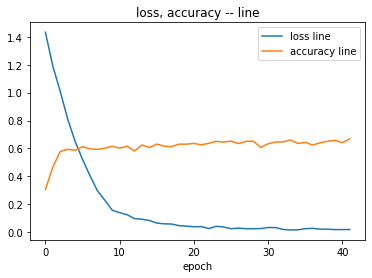

In [ ]:
torch.cuda.empty_cache()

train_dataloader, test_dataloader = load_data(test_batch_size = test_batch_size, train_batch_size = train_batch_size, download = True, shuffle = True)

result_no_filter_train_data = train_predict(train_dataloader = train_dataloader, test_dataloader = test_dataloader, lr = lr, epoches = epoches, save_checking_points = True, checking_points_path = checking_points_cpts1)

In [ ]:
process_train_data_via_forgetting(train_dataloader = train_dataloader)
process_train_data_via_tracIn(lr = lr, test_batch_size = test_batch_size, checking_points_path = checking_points_cpts1, train_dataloader = train_dataloader, test_dataloader = test_dataloader)

current_category: 0
1.980274 s
[0.0016773497314453126, 0.0011690870361328125, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375, 0.001084337646484375